In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
from math import exp
import mediapipe as mp
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
path="C:\\Users\\ganga\Jupyter Notebook\\FINAL YEAR PROJECT\\"

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    print(f'Pose: {pose}')
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    print(f'Face: {face}')
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    print(f'Left Hand: {lh}')
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    print(f'Right Hand: {rh}')
    return np.concatenate([pose, face, lh, rh])

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['','hello', 'thank you', 'eat'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'': 0, 'hello': 1, 'thank you': 2, 'eat': 3}

In [10]:
import pandas as pd
df=pd.DataFrame(columns=['model','MP_Data_gangadhar_v2','MP_Data_gangadhar_v3','MP_Data_jagadesh','MP_Data_jagadesh_v2','MP_Data_venky','MP_Data_venky_v2','MP_Data_kundan_v1','MP_Data_kundan_v2'])
df

,model,MP_Data_gangadhar_v2,MP_Data_gangadhar_v3,MP_Data_jagadesh,MP_Data_jagadesh_v2,MP_Data_venky,MP_Data_venky_v2,MP_Data_kundan_v1,MP_Data_kundan_v2


In [11]:
for i in range(6,12):
    _lst=["SignModV#.h5".replace('#',str(i))]
    model = load_model(_lst[0])
    print(_lst[0])
    for tst_path in ['MP_Data_gangadhar_v2','MP_Data_gangadhar_v3','MP_Data_jagadesh','MP_Data_jagadesh_v2','MP_Data_venky','MP_Data_venky_v2','MP_Data_kundan_v1','MP_Data_kundan_v2']:
        test_DATA_PATH=tst_path
        sequences_test, labels_test = [], []
        for action in actions:
            for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences_test.append(window)
                labels_test.append(label_map[action])
        sequences_test=np.array(sequences_test)
        labels_test = to_categorical(labels_test).astype(int)
        ypred = model.predict(sequences_test)
        ytrue = np.argmax(labels_test, axis=1).tolist()
        ypred = np.argmax(ypred, axis=1).tolist()
        __x=accuracy_score(ytrue, ypred)
        _lst.append(__x)
        print(__x)
    df.loc[len(df.index)]=_lst
    print()

SignModV6.h5
4/4 [==============================] - 1s 48ms/step
0.975
4/4 [==============================] - 0s 31ms/step
0.825
4/4 [==============================] - 0s 30ms/step
0.975
4/4 [==============================] - 0s 30ms/step
0.75
4/4 [==============================] - 0s 28ms/step
0.9416666666666667
4/4 [==============================] - 0s 31ms/step
0.7520661157024794
4/4 [==============================] - 0s 29ms/step
0.8583333333333333
4/4 [==============================] - 0s 30ms/step
0.7333333333333333

SignModV7.h5
4/4 [==============================] - 0s 31ms/step
0.95
4/4 [==============================] - 0s 41ms/step
0.85
4/4 [==============================] - 0s 29ms/step
0.95
4/4 [==============================] - 0s 28ms/step
0.575
4/4 [==============================] - 0s 29ms/step
0.95
4/4 [==============================] - 0s 29ms/step
0.7355371900826446
4/4 [==============================] - 0s 30ms/step
0.9166666666666666
4/4 [=========================

In [12]:
df

,model,MP_Data_gangadhar_v2,MP_Data_gangadhar_v3,MP_Data_jagadesh,MP_Data_jagadesh_v2,MP_Data_venky,MP_Data_venky_v2,MP_Data_kundan_v1,MP_Data_kundan_v2
0,SignModV6.h5,0.975000,0.825000,0.975000,0.750000,0.941667,0.752066,0.858333,0.733333
1,SignModV7.h5,0.950000,0.850000,0.950000,0.575000,0.950000,0.735537,0.916667,0.625000
2,SignModV8.h5,0.966667,0.975000,0.941667,0.666667,0.958333,0.595041,0.966667,0.758333
3,SignModV9.h5,1.000000,0.958333,0.958333,0.941667,0.950000,0.933884,0.966667,0.891667
4,SignModV10.h5,0.991667,0.975000,0.983333,0.958333,0.958333,0.966942,0.975000,0.841667
5,SignModV11.h5,1.000000,0.966667,0.975000,0.966667,0.975000,0.950413,0.991667,0.975000


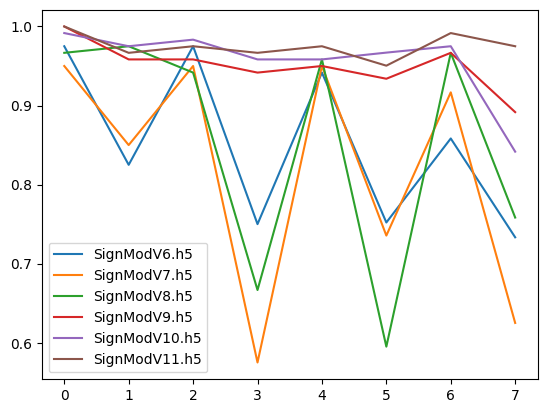

In [13]:
for i in range(len(df)):
    plt.plot(range(8),df.iloc[i,1:],label=df.iloc[i,0])
plt.legend()
plt.show()